# Limpieza y procesamiento de los datos

Importamos las librerias necesarias

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
def process_weather_data(csv_path):
    """
    Procesa datos meteorológicos, limpia columnas con muchos valores nulos
    y estima valores faltantes cuando es apropiado.
    
    Args:
        csv_path: Ruta al archivo CSV
    Returns:
        DataFrame procesado
    """
    
    df = pd.read_csv(csv_path)
    
    df['date'] = pd.to_datetime(df['date'])

    df = df.drop(columns=['snow', 'wpgt', 'tsun'])

    # Si [tavg](Temperatura media) está vacío lo rellenamos con la media de [tmin](Temperatura mínima) y [tmax](Temperatura máxima)
    df['tavg'] = df['tavg'].fillna((df['tmin'] + df['tmax']) / 2)
    
    # Identificamos las columnas numéricas para interpolarlas
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Interpolamos valores faltantes para cada columna numérica
    for col in numeric_columns:
        # Usamos interpolación linear para gaps pequeños (hasta 5 días)
        df[col] = df[col].interpolate(method='linear', limit=5)
    
    return df

Procesamos los datos

In [ ]:
df_processed = process_weather_data("export.csv")

Verificamos la continuidad de las fechas

In [ ]:
date_gaps = df_processed['date'].diff().dt.days
if (date_gaps > 1).any():
    print("\nSe encontraron gaps en las fechas:")
    gaps_mask = date_gaps > 1
    print(df_processed['date'][gaps_mask])

Exportamos los datos procesados a csv

In [ ]:
df_processed.to_csv('datos_procesados.csv', index=False)

# Análisis de los datos

In [ ]:
# Cargamos los datos
df = pd.read_csv("datos_procesados.csv")

# Convertimos la fecha a datetime
df['date'] = pd.to_datetime(df['date'])

# Establecemos la fecha como índice
df.set_index('date', inplace=True)

Estadísticas descriptivas

In [ ]:
print("Estadísticas básicas ", df.describe())
print("Días con lluvia ", len(df[df['prcp'] > 0]))
print("Temperatura máxima registrada ", df['tmax'].max())
print("Temperatura mínima registrada ", df['tmin'].min())
print("Velocidad máxima del viento ", df['wspd'].max())
print("Presión atmosférica promedio ", df['pres'].mean())


Estadísticas básicas                tavg         tmin         tmax         prcp         wdir  \
count  7663.000000  7663.000000  7663.000000  7663.000000  1452.000000   
mean     15.639049    10.773894    20.849178     1.172713   157.119146   
std       7.782261     6.707731     9.000051     4.107447   110.317483   
min      -3.200000    -7.400000     0.100000     0.000000     1.000000   
25%       9.100000     5.300000    13.000000     0.000000    46.000000   
50%      14.650000    10.200000    19.700000     0.000000   157.500000   
75%      22.200000    16.400000    28.600000     0.000000   251.000000   
max      33.700000    26.200000    40.700000   107.800000   360.000000   

              wspd         pres  
count  1452.000000  1452.000000  
mean     11.272176  1018.039979  
std       4.437794     6.604454  
min       3.500000   994.100000  
25%       7.900000  1013.775000  
50%      10.700000  1017.150000  
75%      13.600000  1021.900000  
max      31.000000  1039.100000  
Días 

Generamos gráficos de análisis de temperatura

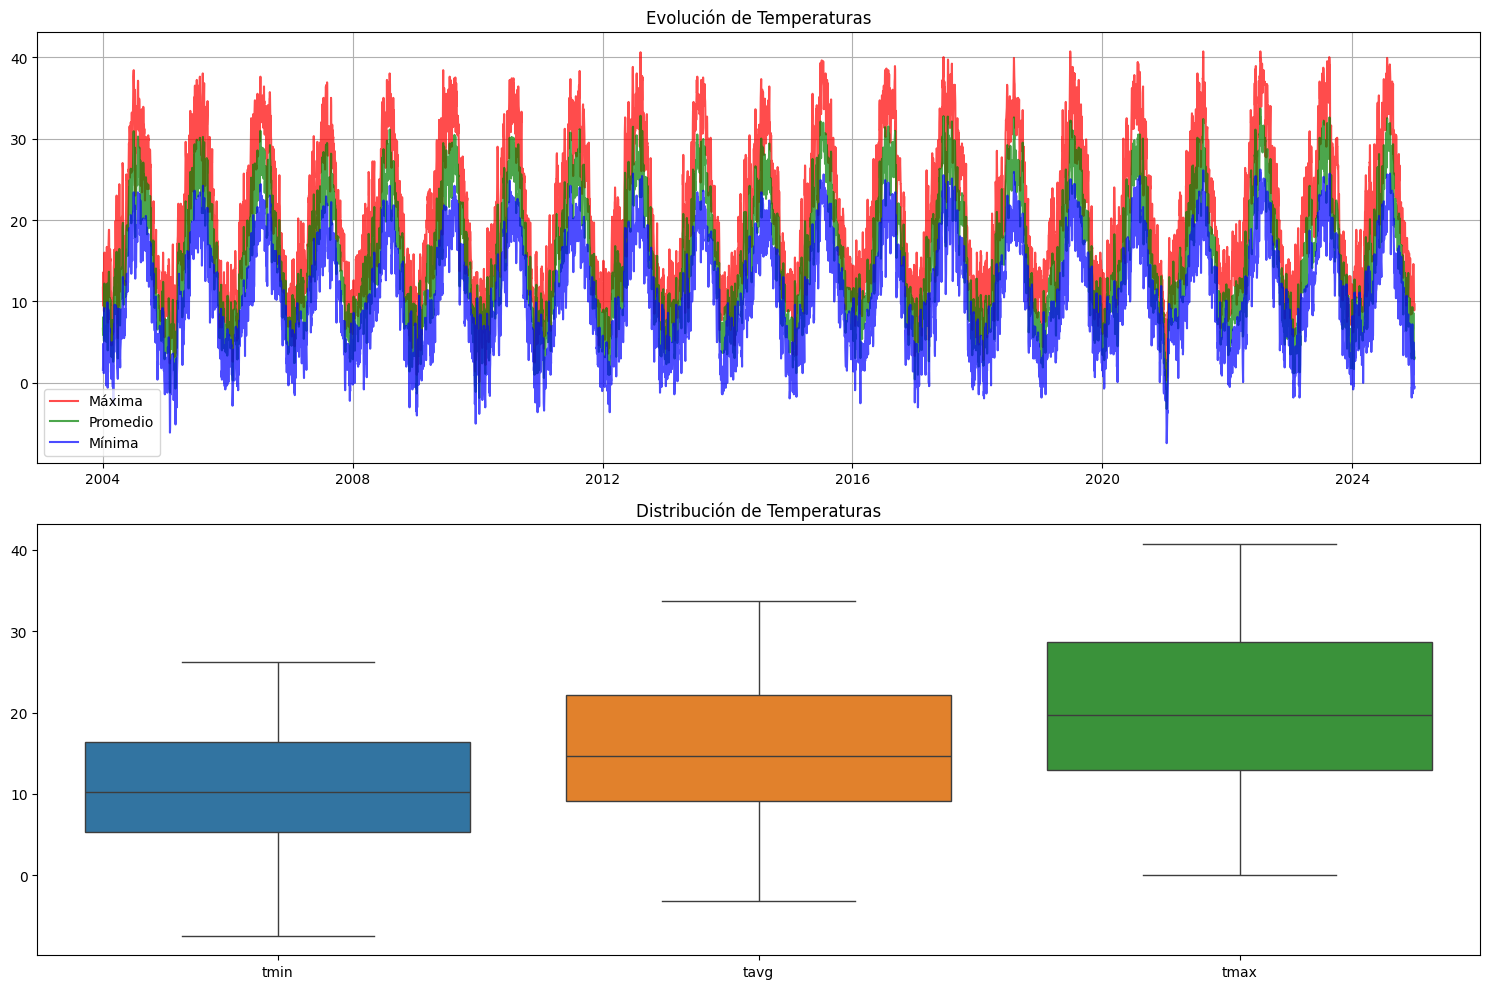

In [ ]:
plt.figure(figsize=(15, 10))

# Subplot 1: Temperaturas diarias
plt.subplot(2, 1, 1)
plt.plot(df.index, df['tmax'], label='Máxima', color='red', alpha=0.7)
plt.plot(df.index, df['tavg'], label='Promedio', color='green', alpha=0.7)
plt.plot(df.index, df['tmin'], label='Mínima', color='blue', alpha=0.7)
plt.title('Evolución de Temperaturas')
plt.legend()
plt.grid(True)

# Subplot 2: Distribución de temperaturas
plt.subplot(2, 1, 2)
sns.boxplot(data=df[['tmin', 'tavg', 'tmax']])
plt.title('Distribución de Temperaturas')

plt.tight_layout()
plt.show()

Generamos matriz de correlación entre variables

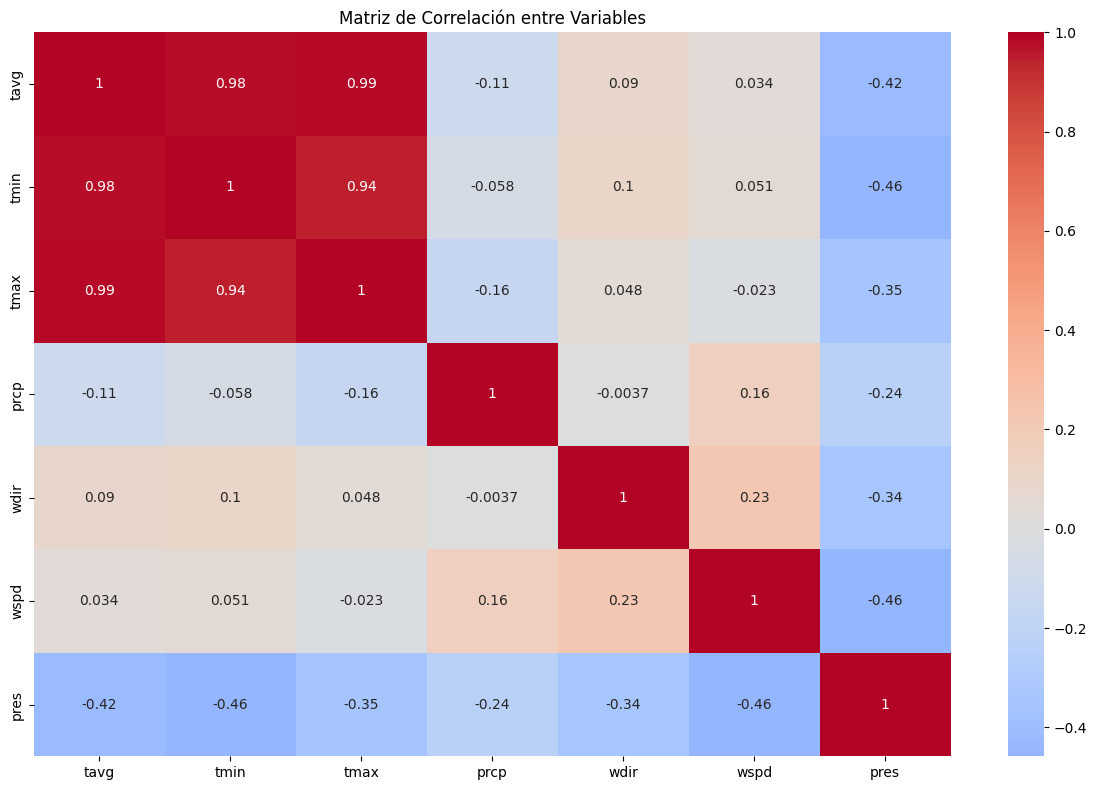

In [33]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación entre Variables')
plt.tight_layout()
plt.show()

Análisis del viento (dirección y velocidad)

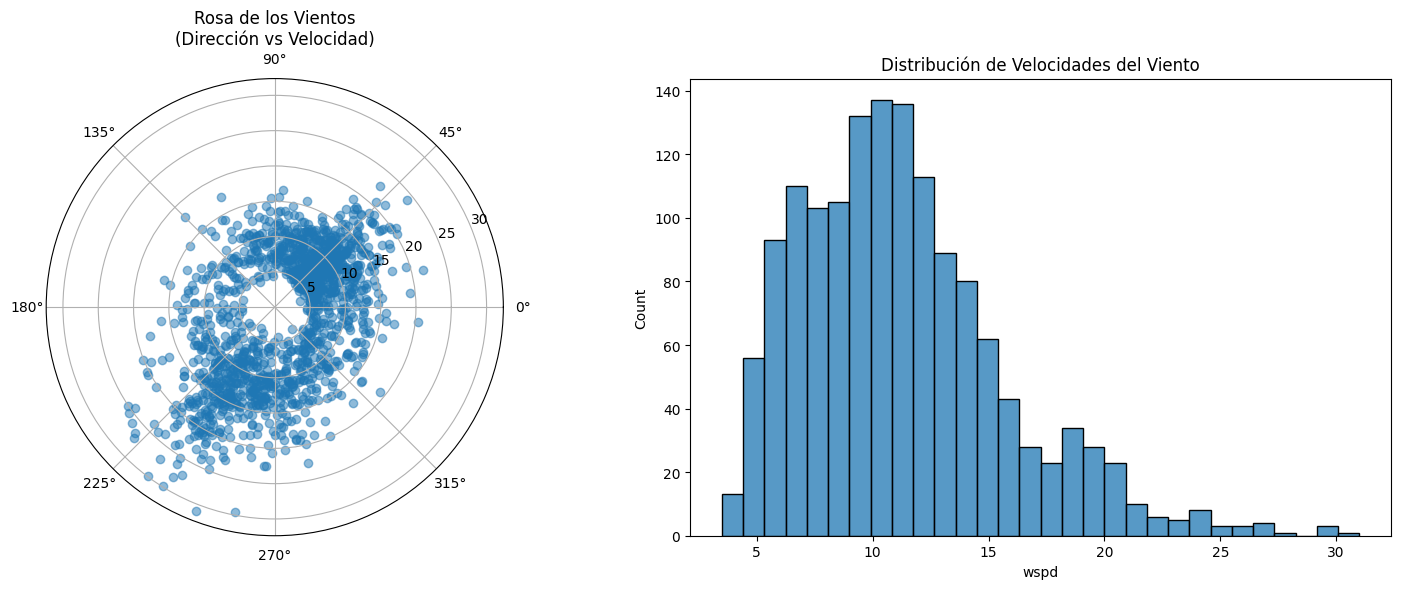

In [34]:
plt.figure(figsize=(15, 6))
    
# Subplot 1: Rosa de los vientos
plt.subplot(1, 2, 1, projection='polar')
plt.scatter(np.radians(df['wdir']), df['wspd'], alpha=0.5)
plt.title('Rosa de los Vientos\n(Dirección vs Velocidad)')
    
# Subplot 2: Distribución de velocidades
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='wspd', bins=30)
plt.title('Distribución de Velocidades del Viento')
    
plt.tight_layout()
plt.show()

Análisis de precipitaciones

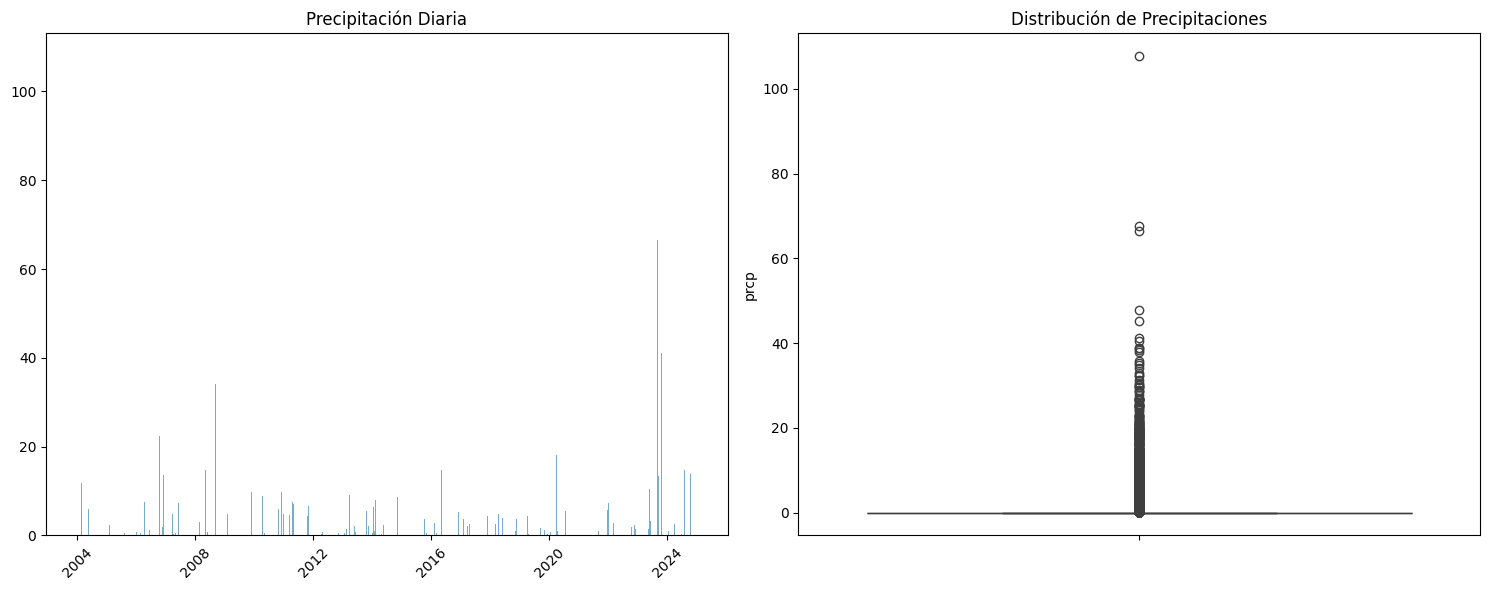

In [35]:
plt.figure(figsize=(15, 6))
    
# Subplot 1: Precipitación diaria
plt.subplot(1, 2, 1)
plt.bar(df.index, df['prcp'], alpha=0.6)
plt.title('Precipitación Diaria')
plt.xticks(rotation=45)
    
# Subplot 2: Distribución de precipitaciones
plt.subplot(1, 2, 2)
sns.boxplot(y=df['prcp'])
plt.title('Distribución de Precipitaciones')
    
plt.tight_layout()
plt.show()